In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
sys.path.append(os.pardir)

import matplotlib.pyplot as plt
%matplotlib inline

In [27]:
from hmm.hessian import *

In [3]:
from hmm.hmm import HMM
from hmm.gaussian_hmm import GaussHMM

# make a fake model

In [22]:
model = GaussHMM(K = 2, D = 2)

In [23]:
model.means = np.array([ [-1., 1.], [1., 1.] ])
model.covs = np.stack([0.5*np.eye(2) for _ in range(2)])


make fake 2-D data

In [25]:
h,z = model.sample(50)
z.shape

(50, 2)

In [ ]:
# get loglikelihood
model.score(z)

# load a learned model

In [4]:
path_to_model = '/home/songbird/datapartition/mdgan_output/daily_gan/p20r16_nz12_alldaysnets/day_17/hmm_hiddensize_12/model_day_17.pkl'

In [5]:
mm = joblib.load(path_to_model)

In [6]:
model = mm['model']

In [15]:
path_to_data = '/home/songbird/datapartition/mdgan_output/daily_gan/p20r16_nz12_alldaysnets/day_17/hmm_hiddensize_12/data_and_scores_day_17.pkl'

In [16]:
data = joblib.load(path_to_data)

In [17]:
traindata = data['ztrain']
len(traindata)

907

In [18]:
CC = model.covars_
CC.shape

(12, 12, 12)

# prepare the parameters

In [7]:
CUDA=True

In [9]:
params = {}
params['means'] = model.means_
params['covars'] = np.squeeze(model.covars_)
params['transmat'] = model.transmat_
params['start_prob'] = model.startprob_

mu, varss, A, pi, B, _ = prepare_params_no_redundant(params)
#varss = cov[:,0,0]

if CUDA:
    mu = mu.cuda()
    varss = varss.cuda()
    A  = A.cuda()
    pi = pi.cuda()
    B = B.cuda()

ndim = mu.shape[-1]
nstates = mu.shape[0]
totparams = ndim*nstates + nstates*ndim + (nstates*(nstates-1)) + (nstates-1)
print(totparams)

431


# check transition matrices for zeros

In [10]:
model.transmat_prior

1.0

In [11]:
TT = model.transmat_

In [12]:
TT.shape

(12, 12)

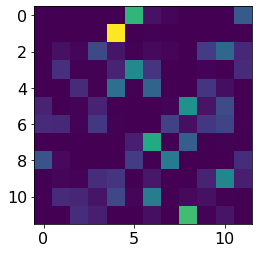

In [13]:
plt.imshow(TT)

In [31]:
model.startprob_prior

1.0

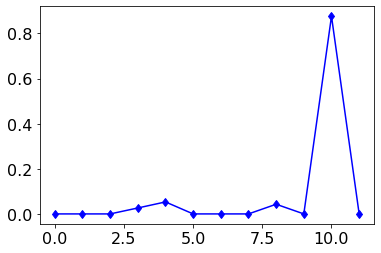

In [14]:
PI = model.startprob_
plt.plot(PI, '-db')

# check hmmlearn likelihood to own function

In [21]:
model.startprob_.sum()

0.9999087084754078

In [37]:
isinstance(A, torch.Tensor)

True

In [22]:
traindata[50].shape

(36, 12)

In [26]:
varss.shape

torch.Size([12, 12, 12])

In [29]:
logLLcalculation_scaled_noredudantA(traindata[50], mu, varss, A, pi, B, T = traindata[50].shape[0], cuda=True)

tensor(-103.0724, device='cuda:0', grad_fn=<SumBackward0>)

# get hessian

In [30]:
# subsample the data
ids = np.random.choice(len(traindata), size=10, replace=False)
zt = [traindata[i] for i in ids]

In [40]:
len(zt)

10

In [ ]:

# get hessian
print('...... computing Hessian over %d sequences ......'%(len(zt)))

Htotal = np.zeros((totparams, totparams))

for i, z in enumerate(zt):
    
    H = compute_hessian(mu, varss, A, pi, B, z, cuda=CUDA)
    
    if np.sum(np.isnan(H))>0.:
        continue
        
    Htotal += H 
    print('# done with %d / %d seqs # '%(i,len(zt)))


Hdet = np.linalg.det(Htotal)

if Hdet == 0.:
    # it shouldn't be zero
    pdb.set_trace()

# loglikelihood
LL =  model.score(np.concatenate(traindata), [len(t) for t in traindata])
# BIC
BIC = -2*LL + np.log(Hdet)

In [37]:
'a'

'a'

In [42]:

def create_hess_mat_diagvar_symm_noredundant(H, ndim = 16, nstates = 5):
    
    totparams = ndim*nstates + nstates*ndim + (nstates*(nstates-1)) + (nstates-1)
    Hess = np.zeros((totparams,totparams))
    row = 0
    row_start = 0
    col1 = 0
    
    ##### NOW COV #####f
    # covs vs means
    Hcov = H[1]
    pdb.set_trace()
    for k in range(nstates):
        
        for j in range(ndim):
            
            x = Hcov[0][k,j].flatten() # vectorized
            col2 = col1 + len(x)
            Hess[row, col1:col2] = x.detach().cpu().numpy()
            
            row += 1
            
    col1 = col2*1
    row = row_start*1
    
    # covs vs covs
    for k in range(nstates):
        for j in range(ndim):
            
            x = Hcov[1][k,j].flatten()
            col2 = col1 + len(x)
            Hess[row, col1:col2] = x.detach().cpu().numpy()
            row += 1
            
    col1 = col2*1
    row = row_start*1
    
    # covs vs A
    for k in range(nstates):
        for j in range(ndim):
            
            x = Hcov[2][k,j].flatten() # vectorized matrix
            col2 = col1 + len(x)
            Hess[row, col1:col2] = x.detach().cpu().numpy()
            row += 1
            
    col1 = col2*1
    row = row_start*1
    
    # covs vs pi
    for k in range(nstates):
        for j in range(ndim):
            
            x = Hcov[3][k,j].flatten() # vectorized matrix
            col2 = col1 + len(x)
            Hess[row, col1:col2] = x.detach().cpu().numpy()
            row += 1

    col1 = 0
    row = row_start*1
    row += nstates
    row_start = row*1
    
    
    ### now do means
    
    Hmu = H[0]
    # means vs means
    for k in range(nstates):
        for j in range(ndim):
            x = Hmu[0][k,j].flatten() # vectorized matrix
            col2 = col1 + len(x)
            Hess[row, col1:col2] = x.detach().cpu().numpy()
            row += 1
    col1 = col2*1
    row = row_start*1
    
    # means vs covs
    for k in range(nstates):
        for j in range(ndim):
            x = Hmu[1][k,j].flatten() # need to flatten
            col2 = col1 + len(x)
            Hess[row, col1:col2] = x.detach().cpu().numpy()
            row += 1
    col1 = col2*1
    row = row_start*1
    
    # means vs A
    for k in range(nstates):
        for j in range(ndim):
            x = Hmu[2][k,j].flatten() # vectorized matrix
            col2 = col1 + len(x)
            Hess[row, col1:col2] = x.detach().cpu().numpy()
            row += 1
    col1 = col2*1
    row = row_start*1
    
    # means vs pi
    for k in range(nstates):
        for j in range(ndim):
            x = Hmu[3][k,j].flatten() # vectorized matrix
            col2 = col1 + len(x)
            Hess[row, col1:col2] = x.detach().cpu().numpy()
            row += 1
    row = row_start*1
    row += ndim*nstates
    row_start = row*1
    col1 = 0
    
    
    #### NOW DO A ####
    HA = H[2]
    # A vs means
    for k in range(nstates):
        for j in range(nstates-1):
            x = HA[0][k,j].flatten() # vectorized matrix
            col2 = col1 + len(x)
            Hess[row, col1:col2] = x.detach().cpu().numpy()
            row += 1
    col1 = col2*1
    row = row_start*1
    
    # A vs covs
    for k in range(nstates):
        for j in range(nstates-1):
            x = HA[1][k,j] # vectorized matrix
            col2 = col1 + len(x)
            Hess[row, col1:col2] = x.detach().cpu().numpy()
            row += 1
    col1 = col2*1
    row = row_start*1
    
    # A vs A
    for k in range(nstates):
        for j in range(nstates-1):
            x = HA[2][k,j].flatten() # vectorized matrix
            col2 = col1 + len(x)
            Hess[row, col1:col2] = x.detach().cpu().numpy()
            row += 1
    col1 = col2*1
    row = row_start*1
    
    # A vs pi
    for k in range(nstates):
        for j in range(nstates-1):
            x = HA[3][k,j].flatten() # vectorized matrix
            col2 = col1 + len(x)
            Hess[row, col1:col2] = x.detach().cpu().numpy()
            row += 1
    
    col1 = 0
    row = row_start*1
    row += nstates*(nstates-1)
    row_start = row*1
    
    #### NOW DO pi ####
    Hpi = H[3]
    # pi vs means
    for k in range(nstates-1):
        x = Hpi[0][k].flatten() # vectorized matrix
        col2 = col1 + len(x)
        Hess[row, col1:col2] = x.detach().numpy()
        row += 1
    col1 = col2*1
    row = row_start*1
    
    # pi vs covs
    for k in range(nstates-1):
        x = Hpi[1][k].flatten() # vectorized matrix
        col2 = col1 + len(x)
        Hess[row, col1:col2] = x.detach().numpy()
        row += 1
    col1 = col2*1
    row = row_start*1
    
    # pi vs A
    for k in range(nstates-1):
        x = Hpi[2][k].flatten() # vectorized matrix
        col2 = col1 + len(x)
        Hess[row, col1:col2] = x.detach().numpy()
        row += 1
    col1 = col2*1
    row = row_start*1
    
    # pi vs pi
    for k in range(nstates-1):
        x = Hpi[3][k] # already vector
        col2 = col1 + len(x)
        Hess[row, col1:col2] = x.detach().numpy()
        row += 1
        
    # take only upper triangle
    #HH = np.zeros_like(Hess)
    #HH = np.triu(Hess)
    #Hess = HH + np.triu(Hess,k=1).T
    return Hess

In [41]:
def compute_hessian(mu, varss, A, pi, B, data, cuda=False):
    
    data = torch.from_numpy(data).float()
    data.requires_grad = False
    if cuda:
        data = data.cuda()
    H = torch.autograd.functional.hessian(lambda x1,x2,x3,x4: logLLcalculation_scaled_noredudantA(data,x1,x2,x3,x4,B,
                                                                                                  T=data.shape[0],
                                                                                                 cuda=cuda), 
                                      (mu,varss,A,pi), create_graph=False, strict=True)
    
    return create_hess_mat_diagvar_symm_noredundant(H, data.shape[-1], mu.shape[0]) 